In [1]:
import numpy as np 
import pandas as pd
import os
import torch
import cv2
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading data 

In [6]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),  
])

def load_images_and_masks(data_dir):

    images = []
    masks = []
    for filename in os.listdir(os.path.join(data_dir, "JPEGImages")):
        if filename.endswith(".jpg"):
            img_path = os.path.join(data_dir, "JPEGImages", filename)
            mask_path = os.path.join(data_dir, "SegmentationClass", filename.replace(".jpg", ".png"))
            if os.path.exists(img_path) and os.path.exists(mask_path):
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if img is not None and mask is not None:
                    img = cv2.resize(img, (224, 224))
                    mask = cv2.resize(mask, (224, 224))
                    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
                    images.append(torch.tensor(img, dtype=torch.float32))
                    masks.append(torch.tensor(mask, dtype=torch.float32))
                else:
                    print(f"Error loading {filename} or its mask")
    return images, masks

data_dir = '/kaggle/input/pascal-voc-2012/VOC2012'
images, masks = load_images_and_masks(data_dir)
print(len(images), len(masks))


2913 2913


In [7]:
print(images[0].shape)

torch.Size([224, 224, 3])


# Making custom dataset

In [8]:
class CustomDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        return image, mask

    def split_dataset(self, train_size=0.8, val_size=0.2, shuffle=True):
        dataset_size = len(self)
        train_size = int(train_size * dataset_size)
        val_size = dataset_size - train_size
        train_dataset, val_dataset = random_split(self, [train_size, val_size], generator=torch.Generator().manual_seed(42))
        return train_dataset, val_dataset
    
dataset = CustomDataset(images, masks, transform=transform)
train_dataset, val_dataset = dataset.split_dataset()
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=8, shuffle=True)

print(len(train_loader))


# Defining Model architecture

In [44]:

class SegNet(nn.Module):

    def __init__(self, in_c=3, out=3, BN_momentum=0.5):
        super(SegNet, self).__init__()
        self.in_c = in_c
        self.out = out

        self.MaxEn = nn.MaxPool2d(2, stride=2, return_indices=True) 

        self.ConvEn11 = nn.Conv2d(self.in_c, 64, kernel_size=3, padding=1)
        self.BNEn11 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvEn12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNEn12 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvEn21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.BNEn21 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvEn22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn22 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvEn31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.BNEn31 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn33 = nn.BatchNorm2d(256, momentum=BN_momentum)

        self.ConvEn41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.BNEn41 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn43 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.ConvEn51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn51 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn53 = nn.BatchNorm2d(512, momentum=BN_momentum)
        
        #upsampling
        self.MaxDe = nn.MaxUnpool2d(2, stride=2) 

        self.ConvDe53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe53 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe51 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.ConvDe43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe43 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe41 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.BNDe41 = nn.BatchNorm2d(256, momentum=BN_momentum)

        self.ConvDe33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe33 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.BNDe31 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvDe22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe22 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvDe21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.BNDe21 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvDe12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNDe12 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvDe11 = nn.Conv2d(64, self.out, kernel_size=3, padding=1)
        self.BNDe11 = nn.BatchNorm2d(self.out, momentum=BN_momentum)

    def forward(self, x):

        x = F.relu(self.BNEn11(self.ConvEn11(x))) 
        x = F.relu(self.BNEn12(self.ConvEn12(x))) 
        x, ind1 = self.MaxEn(x)
        size1 = x.size()
        x = F.relu(self.BNEn21(self.ConvEn21(x))) 
        x = F.relu(self.BNEn22(self.ConvEn22(x))) 
        x, ind2 = self.MaxEn(x)
        size2 = x.size()
        x = F.relu(self.BNEn31(self.ConvEn31(x))) 
        x = F.relu(self.BNEn32(self.ConvEn32(x))) 
        x = F.relu(self.BNEn33(self.ConvEn33(x)))   
        x, ind3 = self.MaxEn(x)
        size3 = x.size()
        x = F.relu(self.BNEn41(self.ConvEn41(x))) 
        x = F.relu(self.BNEn42(self.ConvEn42(x))) 
        x = F.relu(self.BNEn43(self.ConvEn43(x)))   
        x, ind4 = self.MaxEn(x)
        size4 = x.size()
        x = F.relu(self.BNEn51(self.ConvEn51(x))) 
        x = F.relu(self.BNEn52(self.ConvEn52(x))) 
        x = F.relu(self.BNEn53(self.ConvEn53(x)))   
        x, ind5 = self.MaxEn(x)
        size5 = x.size()
        x = self.MaxDe(x, ind5, output_size=size4)
        x = F.relu(self.BNDe53(self.ConvDe53(x)))
        x = F.relu(self.BNDe52(self.ConvDe52(x)))
        x = F.relu(self.BNDe51(self.ConvDe51(x)))
        x = self.MaxDe(x, ind4, output_size=size3)
        x = F.relu(self.BNDe43(self.ConvDe43(x)))
        x = F.relu(self.BNDe42(self.ConvDe42(x)))
        x = F.relu(self.BNDe41(self.ConvDe41(x)))
        x = self.MaxDe(x, ind3, output_size=size2)
        x = F.relu(self.BNDe33(self.ConvDe33(x)))
        x = F.relu(self.BNDe32(self.ConvDe32(x)))
        x = F.relu(self.BNDe31(self.ConvDe31(x)))
        x = self.MaxDe(x, ind2, output_size=size1)
        x = F.relu(self.BNDe22(self.ConvDe22(x)))
        x = F.relu(self.BNDe21(self.ConvDe21(x)))
        x = self.MaxDe(x, ind1)
        x = F.relu(self.BNDe12(self.ConvDe12(x)))
        x = self.ConvDe11(x)
        #x = F.softmax(x, dim=1)
        return x
model = SegNet(in_c=3, out=3)  
model

SegNet(
  (MaxEn): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ConvEn11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn11): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (ConvEn12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn12): BatchNorm2d(64, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (ConvEn21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn21): BatchNorm2d(128, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (ConvEn22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn22): BatchNorm2d(128, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (ConvEn31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BNEn31): BatchNorm2d(256, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (ConvEn32): Conv2d(256, 256, kernel_s

# Train the model 

In [45]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

    def train(self, num_epochs=10):
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            for images, masks in self.train_loader:
                images = images.to(self.device)
                masks = masks.to(self.device)
                self.optimizer.zero_grad()
                images = images.permute(0, 3, 1, 2)
                masks = masks.permute(0, 3, 1, 2)
                masks = masks.expand(-1, 3, -1, -1)
                outputs = self.model(images)
                outputs_s = outputs.squeeze(0)
                masks_s = masks.squeeze(0)

                loss = self.criterion(outputs_s, masks_s)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * images.size(0)

            epoch_loss = running_loss / len(self.train_loader.dataset)
            val_accuracy = self.validate()

            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {epoch_loss:.4f}, '
                  f'Val Accuracy: {val_accuracy:.4f}')

    def validate(self):
        self.model.eval()
        correct_pixels = 0
        total_pixels = 0
        with torch.no_grad():
            for images, masks in self.val_loader:
                images = images.to(self.device)
                masks = masks.to(self.device)
                images = images.permute(0, 3, 1, 2)
                masks = masks.permute(0, 3, 1, 2)
                masks = masks.expand(-1, 3, -1, -1)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                _, mask_p = torch.max(masks, 1)
                correct_pixels += (predicted == mask_p).sum().item()
                total_pixels += masks.numel()

        accuracy = correct_pixels / total_pixels  # pixel accuracy
        return accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
trainer = Trainer(model=model, train_loader=train_loader, val_loader=val_loader,
                  criterion=criterion, optimizer=optimizer, device=device)
trainer.train()


Epoch [1/10], Train Loss: 3832.7396, Val Accuracy: 0.1227
Epoch [2/10], Train Loss: 3432.3541, Val Accuracy: 0.1629
Epoch [3/10], Train Loss: 3367.3639, Val Accuracy: 0.1220
Epoch [4/10], Train Loss: 3331.0405, Val Accuracy: 0.1140
Epoch [5/10], Train Loss: 3285.9513, Val Accuracy: 0.1087
Epoch [6/10], Train Loss: 3259.2645, Val Accuracy: 0.1101
Epoch [7/10], Train Loss: 3242.8234, Val Accuracy: 0.1139
Epoch [8/10], Train Loss: 3212.0202, Val Accuracy: 0.1073
Epoch [9/10], Train Loss: 3208.5173, Val Accuracy: 0.0993
Epoch [10/10], Train Loss: 3183.6620, Val Accuracy: 0.1090


# Evaluate the trained model on the test dataset using pixel accuracy, mean IoU, and F1 score.

In [23]:
class ModelEvaluator:
    def __init__(self, device):
        self.device = device

    def evaluate_model(self, model, test_loader):
        model.eval()
        all_predicted = []
        all_ground_truth = []

        with torch.no_grad():
            for images, masks in tqdm(test_loader, desc='Evaluation Progress'):
                images = images.to(self.device)
                masks = masks.to(self.device)
                images = images.permute(0, 3, 1, 2)
                masks = masks.permute(0, 3, 1, 2)
                masks = masks.expand(-1, 3, -1, -1)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                all_predicted.append(predicted.cpu().numpy())
                _, mask_p = torch.max(masks, 1)
                all_ground_truth.append(mask_p.cpu().numpy())

        all_predicted = np.concatenate(all_predicted, axis=0)
        all_ground_truth = np.concatenate(all_ground_truth, axis=0)
        flat_predicted = all_predicted.flatten()
        flat_ground_truth = all_ground_truth.flatten()

        # Pixel accuracy
        pixel_accuracy = accuracy_score(flat_ground_truth, flat_predicted)

        # Mean IoU
        intersection = np.logical_and(all_ground_truth, all_predicted)
        union = np.logical_or(all_ground_truth, all_predicted)
        mean_iou = np.mean(np.sum(intersection) / np.sum(union))

        # F1 score
        f1 = f1_score(flat_ground_truth, flat_predicted, average='weighted')

        return pixel_accuracy, mean_iou, f1

evaluator = ModelEvaluator(device=device)
pixel_acc, mean_iou, f1_score = evaluator.evaluate_model(model=model, test_loader=test_loader)
print(f'Pixel Accuracy: {pixel_acc:.4f}, Mean IoU: {mean_iou:.4f}, F1 Score: {f1_score:.4f}')


# Printing the results

In [47]:
pixel_accuracy, mean_iou, f1 = evaluator.evaluate_model(model, val_loader)
print(f'Pixel Accuracy: {pixel_accuracy:.4f}')
print(f'Mean IoU: {mean_iou:.4f}')
print(f'F1 Score: {f1:.4f}')



Evaluation Progress: 100%|██████████| 73/73 [00:10<00:00,  7.17it/s]


Pixel Accuracy: 0.3269
Mean IoU: 0.1235
F1 Score: 0.4927


# Visualizing the model output for a sample

torch.Size([1, 3, 224, 224])


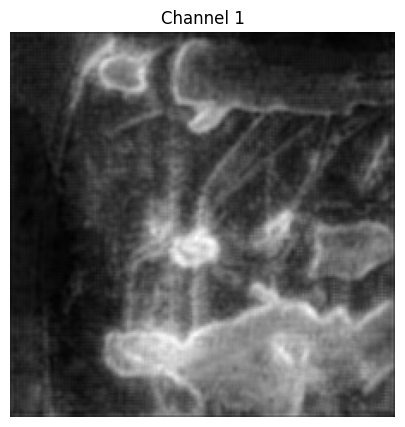

In [56]:
test_image,test_mask = val_dataset[38]
test_image = test_image.permute(2, 1, 0).unsqueeze(0).cuda()
print(test_image.shape)
test_mask = test_mask.permute(2, 1, 0).expand(3, -1, -1).cuda()
outputs = model(test_image)
outputs_s = outputs.squeeze(0)
output_array = outputs_s.permute(1, 2, 0).cpu().detach().numpy()
fig,ax = plt.subplots(1, 1, figsize=(15, 5)) 
ax.imshow(output_array[:, :, 0], cmap='gray')  
ax.axis('off')
ax.set_title('Channel 1')
plt.show()

# Change the backbone model from VGG to some lightweight model

In [40]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),   
            nn.ReLU(),
            nn.MaxPool2d(2, 2),               
            nn.Conv2d(16, 8, 3, padding=1),   
            nn.ReLU(),
            nn.MaxPool2d(2, 2),              
            nn.Conv2d(8, 8, 3, padding=1),   
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1),    
            nn.ReLU(),
            nn.Upsample(scale_factor=2),      
            nn.Conv2d(8, 8, 3, padding=1),  
            nn.ReLU(),
            nn.Upsample(scale_factor=2),      
            nn.Conv2d(8, 16, 3, padding=1),   
            nn.ReLU(),
            nn.Upsample(scale_factor=2),      
            nn.Conv2d(16, 3, 3, padding=1)
            #nn.Sigmoid()                     
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
model_light = Autoencoder()
model_light

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Upsample(scale_factor=2.0, mode

# Training the new model

In [41]:
model_light.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_light.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        images = images.permute(0,3,1,2)
        masks = masks.permute(0,3,1,2)
        masks = masks.expand(-1, 3, -1, -1)
        outputs = model_light(images)
        outputs_s = outputs.squeeze(0)
        masks_s = masks.squeeze(0)
       
        loss = criterion(outputs_s, masks_s)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
     
    epoch_loss = running_loss / len(train_dataset)

    model.eval()
    correct_pixels = 0
    total_pixels = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            images = images.permute(0,3,1,2)
            masks = masks.permute(0,3,1,2)
            masks = masks.expand(-1, 3, -1, -1)
            outputs = model_light(images)
            _, predicted = torch.max(outputs, 1)
            _, mask_s = torch.max(masks, 1)
            correct_pixels += (predicted == mask_s).sum().item()
            total_pixels += masks.numel()

    accuracy = correct_pixels / total_pixels

    print(f'Epoch [{epoch + 1}/{10}], '
          f'Train Loss: {epoch_loss:.4f}, '
          f'Val Accuracy: {accuracy:.4f}')

Epoch [1/10], Train Loss: 3791.1361, Val Accuracy: 0.1689
Epoch [2/10], Train Loss: 3581.1391, Val Accuracy: 0.1023
Epoch [3/10], Train Loss: 3489.2139, Val Accuracy: 0.0991
Epoch [4/10], Train Loss: 3456.7864, Val Accuracy: 0.0851
Epoch [5/10], Train Loss: 3396.2063, Val Accuracy: 0.0841
Epoch [6/10], Train Loss: 3390.5140, Val Accuracy: 0.0772
Epoch [7/10], Train Loss: 3392.2056, Val Accuracy: 0.0747
Epoch [8/10], Train Loss: 3364.6278, Val Accuracy: 0.0635
Epoch [9/10], Train Loss: 3335.9045, Val Accuracy: 0.0605
Epoch [10/10], Train Loss: 3341.2907, Val Accuracy: 0.0680


# Evaluation 

In [43]:
evaluator = ModelEvaluator(device=device)
pixel_accuracy, mean_iou, f1 =evaluator.evaluate_model(model_light, val_loader)

print(f'Pixel Accuracy: {pixel_accuracy:.4f}')
print(f'Mean IoU: {mean_iou:.4f}')
print(f'F1 Score: {f1:.4f}')

Evaluation Progress: 100%|██████████| 73/73 [00:00<00:00, 116.70it/s]


Pixel Accuracy: 0.2040
Mean IoU: 0.1037
F1 Score: 0.3389


# Plotting the output image for a sample for all the 3 channels

In [ ]:
test_image,test_mask = val_dataset[25]
test_image = test_image.permute(2,1,0)
test_image = test_image.unsqueeze(0)
test_mask = test_mask.permute(2,1,0)
test_mask = test_mask.expand(3, -1, -1)
outputs = model_light(test_image)
outputs_s = outputs.squeeze(0)
output_array = outputs.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()

## for channel 1,2,3

fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 
axes[0].imshow(output_array[:, :, 0], cmap='gray')
axes[0].axis('off')
axes[0].set_title('Channel 1')

axes[1].imshow(output_array[:, :, 1], cmap='gray')  
axes[1].axis('off')
axes[1].set_title('Channel 2')

axes[2].imshow(output_array[:, :, 2], cmap='gray')  
axes[2].axis('off')
axes[2].set_title('Channel 3')

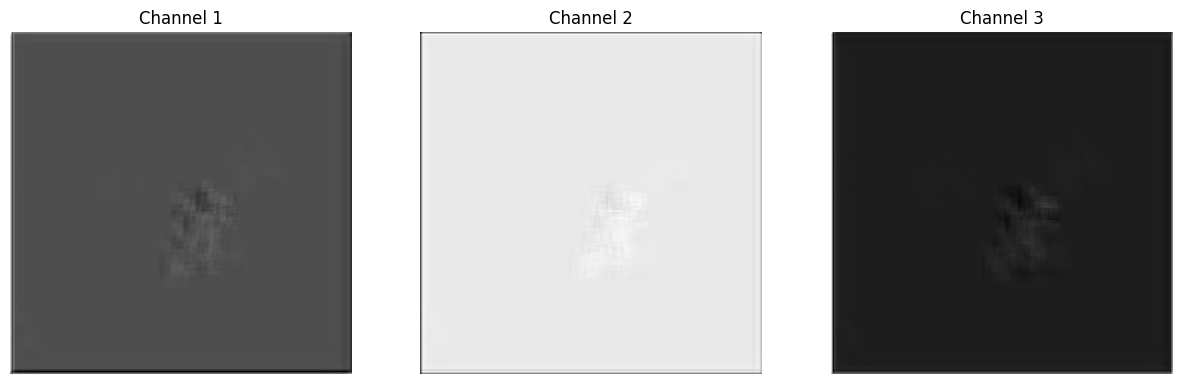

In [48]:
plt.show()

# comparing the performance :-

## Vgg15 base model performance
1. IOU -0.1037
2. F1 - 0.33
3. pixel-accuracy- 0.2040

## Light model (as backbone) performance

1. IOU - 0.12
2. F1 - 0.4927
3. pixel-accuracy - 0.3269



In [ ]:
# Conclusion
The reason for this difference in performance can be attributed to the architectural differences between the two models:

## Vgg15 Base Model:

1. Utilizes a deeper architecture with more convolutional layers (5 convolutional blocks) and larger kernel sizes.
2. More complex architecture may lead to more overfitting on the training data, resulting in lower generalization performance on the validation or test set.
3. May have higher computational complexity due to a larger number of parameters, leading to potential issues with optimization and convergence.

## Light Model:

1. Employs a simpler architecture with fewer convolutional layers (3 convolutional blocks) and smaller kernel sizes.
2. Simpler architecture may result in less overfitting and better generalization performance on unseen data.
3. Potentially lower computational complexity due to fewer parameters, which can lead to faster training and convergence.

In summary, the Light Model achieves better performance due to its simpler architecture, which allows it to generalize better to unseen data and avoid overfitting.
Additionally, the Light Model may be more computationally efficient, contributing to its improved training and inference speed.






